Student name: Alice Kwon
<br>Instructor: Lindsey Berlin
<br>DS-PT-03.02.20

# Module 5 Project

Image classification of Simpson cartoon characters usin Keras. 
<br>Data: was found on kaggle
<br>There was on kaggle approximately 1GB of data which contains separated images of the Simpsons characters.
<br>Our goal is to be able to create a model which will be able to tell apart different characters. 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn
from collections import Counter
import glob
import pickle
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD, Adam
from random import shuffle
%matplotlib inline

Images of characters are not in folders, we are going to associate images with characters using dictionary 
and test folder

In [39]:
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}
pic_size = 64
batch_size = 32
epochs = 200
num_classes = len(map_characters)

In [3]:
def load_test_set(path):
    '''
    input: path to test set
    output: X_test and y_test from test set
    '''
    #make list of pictures and labels
    pics, labels = [], []
    reverse_dict = {v:k for k,v in map_characters.items()}
    
    #separate each picture into character name
    for pic in glob.glob(path+'*.*'):
        char_name = "_".join(pic.split('/')[6].split('_')[:-1])
        
        #attach character name and picture
        if char_name in reverse_dict.keys():
            #print(pic, 'yo')
            temp = cv2.imread(pic)
            temp = cv2.resize(temp, (pic_size,pic_size)).astype('float32') / 255.
            pics.append(temp)
            labels.append(reverse_dict[char_name])
    X_test = np.array(pics)
    y_test = np.array(labels)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    print("Test set", X_test.shape, y_test.shape)
    return X_test, y_test

## Selected Model:
- look at section: Tuning Model. 
- The following is a model with 6 convolutions. 

In [22]:
def create_model_six_conv(input_shape):
    """
    :param input_shape: input shape, generally X_train.shape[1:]
    :return: Keras model, RMS prop optimizer
    """
    
    model = Sequential()
    #one
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    #two
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    #max pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    #three
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #four
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    #maxpooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    #five
    model.add(Conv2D(256, (3, 3), padding='same')) 
    model.add(Activation('relu'))
    #six
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    #max pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    return model, opt

def load_model_from_checkpoint(weights_path, input_shape=(pic_size,pic_size,3)):
    model, opt = create_model_six_conv(input_shape)
    model.load_weights(weights_path)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model
  

In [23]:
model = load_model_from_checkpoint('/Users/alicekwon/desktop/mod5/weights.best.hdf5')
X_test, y_test = load_test_set("/Users/alicekwon/desktop/mod5/kaggle_simpson_testset/")
y_pred = model.predict(X_test)

Test set (890, 64, 64, 3) (890, 18)


In [18]:
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.96      0.94      0.95        48
  apu_nahasapeemapetilon       0.98      0.96      0.97        50
            bart_simpson       0.91      0.96      0.93        50
charles_montgomery_burns       0.91      0.90      0.91        48
            chief_wiggum       1.00      1.00      1.00        50
          comic_book_guy       1.00      0.96      0.98        49
          edna_krabappel       0.98      0.92      0.95        50
           homer_simpson       0.94      0.92      0.93        50
           kent_brockman       1.00      0.96      0.98        50
        krusty_the_clown       0.98      1.00      0.99        50
            lisa_simpson       0.96      0.88      0.92        50
           marge_simpson       0.98      1.00      0.99        50
     milhouse_van_houten       0.94      0.98      0.96        49
             moe_szyslak       0.96      0.96      0.96        50
        

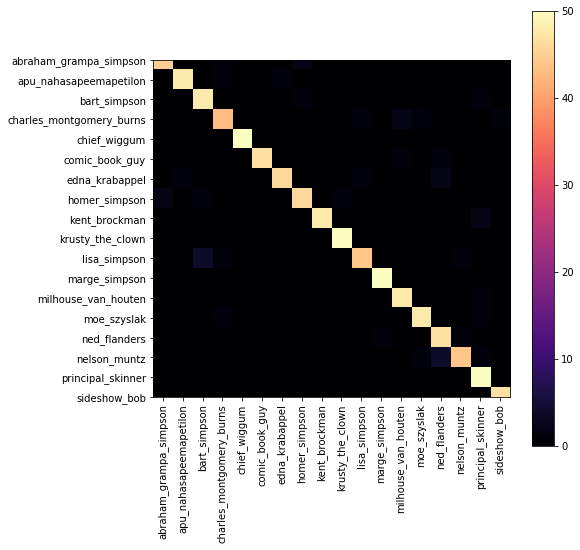

In [32]:
plt.figure(figsize=(8,8))
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest', cmap='magma')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

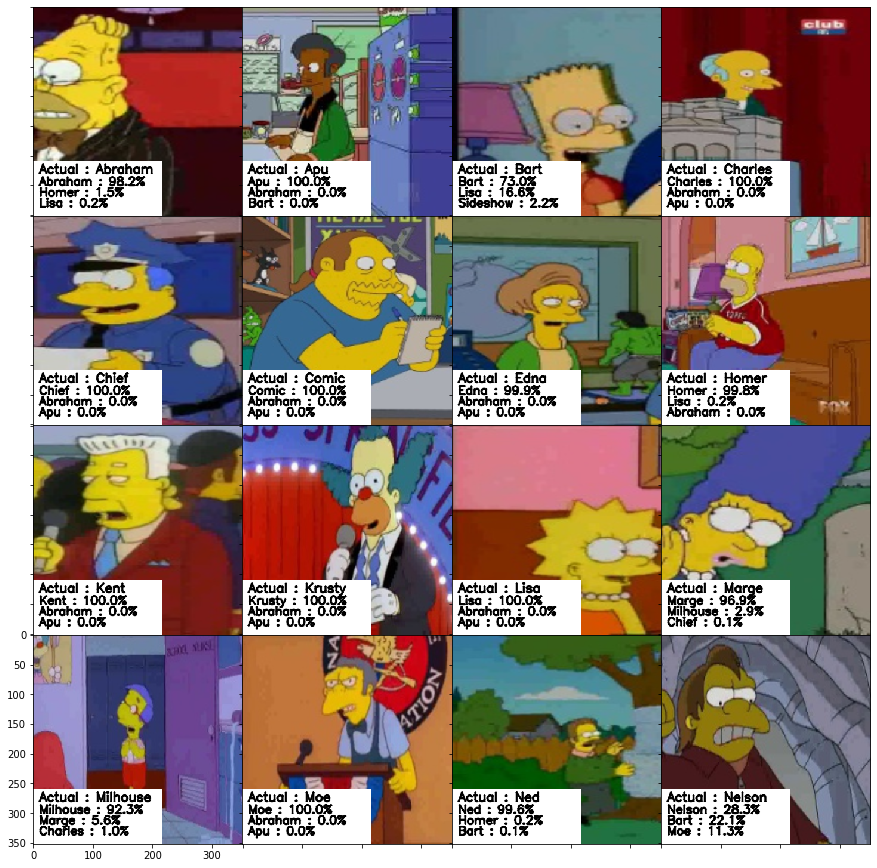

In [8]:
F = plt.figure(1, (15,20))
grid = AxesGrid(F, 111, nrows_ncols=(4, 4), axes_pad=0, label_mode="1")

for i in range(16):
    char = map_characters[i]
    image = cv2.imread(np.random.choice([k for k in glob.glob('kaggle_simpson_testset/*.*') if char in k]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pic = cv2.resize(image, (64, 64)).astype('float32') / 255.
    a = model.predict(pic.reshape(1, 64, 64,3))[0]
    actual = char.split('_')[0].title()
    text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
       key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    img = cv2.resize(img, (352, 352))
    cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
    for k, t in enumerate(text):
        cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)
    grid[i].imshow(img)

## Finding threshold using precision and recall

In [9]:
y_pred = model.predict(X_test, verbose=0)

#make a list for correct and incorrect
compare = np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1)
image_correct, image_incorrect = [i for i, x in enumerate(compare) if x], [i for i, x in enumerate(compare) if not x]

In [40]:
#taking max correct
max_good = np.max(y_pred[image_correct], axis=1)
max_wrong = np.max(y_pred[image_incorrect], axis=1)
#taking difference of best predicted
diff_good = np.diff(np.sort(y_pred[image_correct], axis=1)[:, 16:])
diff_wrong = np.diff(np.sort(y_pred[image_incorrect], axis=1)[:, 16:])
#taking standard deviation
std_good = np.std(y_pred[image_correct], axis=1)
std_wrong = np.std(y_pred[image_incorrect], axis=1)

print("For good predictions : Max : {:.2f}, Difference of 2 best: {:.3f}, STD : {:.2f}".format(np.mean(max_good),
                                                                            np.mean(diff_good),
                                                                            np.mean(std_good)))
print("For wrong predictions : Max : {:.2f}, Difference of 2 worst: {:.3f}, STD : {:.2f}".format(np.mean(max_wrong),
                                                                             np.mean(diff_wrong),
                                                                            np.mean(std_wrong)))

For good predictions : Max : 0.97, Difference of 2 best: 0.954, STD : 0.22
For wrong predictions : Max : 0.53, Difference of 2 worst: 0.317, STD : 0.13


Text(0, 0.5, 'Standard deviation of the prediction')

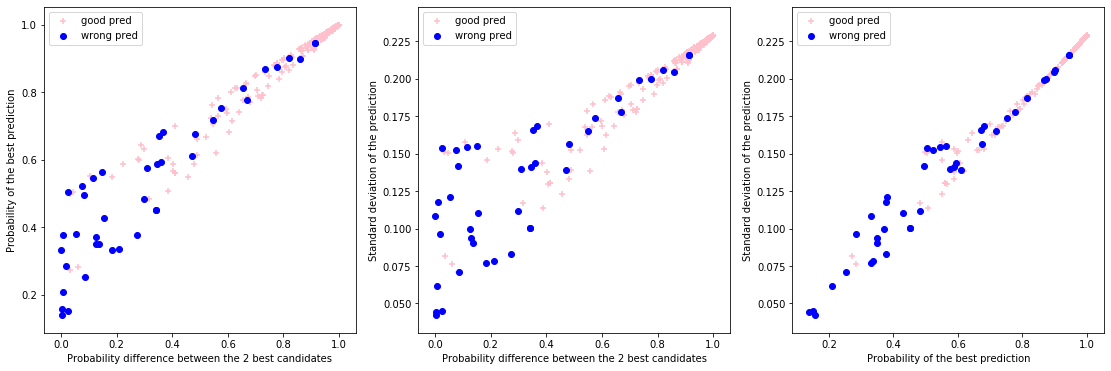

In [11]:
f, ax = plt.subplots(ncols=3, figsize=(19,6))
ax[0].scatter(x = diff_good, y= max_good, c='pink', marker='+', label = 'good pred')
ax[0].scatter(x = diff_wrong, y= max_wrong, c='blue', marker='o', label = 'wrong pred')
ax[0].legend()
ax[0].set_xlabel('Probability difference between the 2 best candidates')
ax[0].set_ylabel('Probability of the best prediction')

ax[1].scatter(x = diff_good, y= std_good, c='pink', marker='+', label = 'good pred')
ax[1].scatter(x = diff_wrong, y= std_wrong, c='blue', marker='o', label = 'wrong pred')
ax[1].legend()
ax[1].set_xlabel('Probability difference between the 2 best candidates')
ax[1].set_ylabel('Standard deviation of the prediction')

ax[2].scatter(x = max_good, y= std_good, c='pink', marker='+', label = 'good pred')
ax[2].scatter(x = max_wrong, y= std_wrong, c='blue', marker='o', label = 'wrong pred')
ax[2].legend()
ax[2].set_xlabel('Probability of the best prediction')
ax[2].set_ylabel('Standard deviation of the prediction')

We create a dictionary as follows:
For each character in map_characters (i.e. the simpson characters):
for each threshold: if y_pred is greater than the threshold we say it is the character. 

In [12]:
y_pred = model.predict(X_test)

indices = [round(k*0.01,2) for k in range(0, 100, 5)] + [0.99]

pos_characters = {cl: {k:[] for k in indices} for cl in map_characters}
for k in indices:
    for i, e in enumerate(y_pred):
        if np.max(e) > k:
            pos_characters[np.argmax(e)][k].append(int(np.argmax(e) == np.argmax(y_test[i])))
pos_characters['ALL'] = {k:np.sum([pos_characters[cl][k] for cl in pos_characters]) for k in indices}

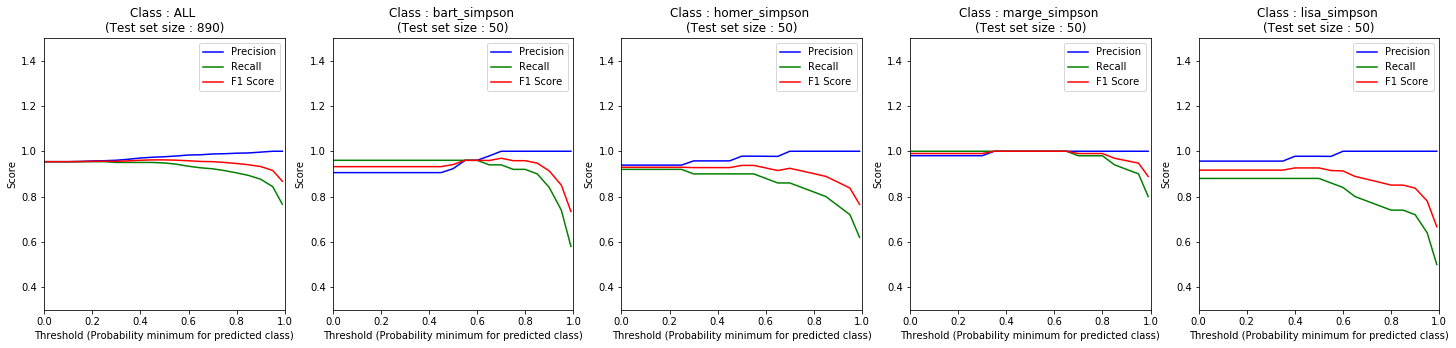

In [13]:
#pick 2,7,11,10 of map_characters i.e. simpsons characters: Bart, Homer, Marge, Lisa
classes_plot = ["ALL", 2, 7, 11, 10]
tr = {"ALL": np.argmax(y_test, axis=1)}
f, ax = plt.subplots(ncols=len(classes_plot), figsize=(len(classes_plot)*5, 5))

for i, cl_plt in enumerate(classes_plot):
    
    #calculate precision, recall and f1_score
    
    precision = {k:np.sum(pos_characters[cl_plt][k])/len(pos_characters[cl_plt][k]) for k in indices}
    recall = {k:np.sum(pos_characters[cl_plt][k])/np.sum(np.argmax(y_test, axis=1)==tr.get(cl_plt, cl_plt))for k in indices}
    f1_score = {k:(2*precision[k]*recall[k])/(precision[k]+recall[k]) for k in indices}
    
    #graph
    
    x,y = zip(*sorted(precision.items()))
    ax[i].plot(x, y, color='blue', label='Precision')
    x,y = zip(*sorted(recall.items()))
    ax[i].plot(x, y, label='Recall', color='green')
    x,y = zip(*sorted(f1_score.items()))
    ax[i].plot(x, y, color='red', label='F1 Score')
    _ = ax[i].set_xlim((0,1))
    _ = ax[i].set_ylabel('Score')
    _ = ax[i].set_xlabel('Threshold (Probability minimum for predicted class)')
    _ = ax[i].set_ylim((0.3,1.5))
    _ = ax[i].legend()
    _ = ax[i].set_title('Class : %s \n(Test set size : %d)' % (map_characters.get(cl_plt, cl_plt), np.sum(np.argmax(y_test, axis=1) == tr.get(cl_plt, cl_plt))))

For each character there is a different threshold that works better. 
For all generally it seems 0.4-0.6holds the best thresholds.

## Tuning Model
We begin with grayscale because color it reduces size and I dont think color matters so much. 

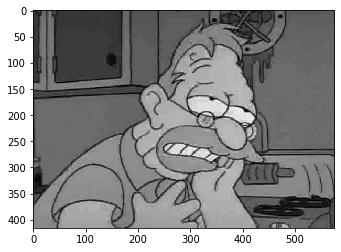

In [61]:
import os

Data_directory = "/Users/alicekwon/desktop/python_tests/mod5/simpsons_dataset"
characters = ['abraham_grampa_simpson', 'apu_nahasapeemapetilon','bart_simpson', 
        'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy', 'edna_krabappel', 
        'homer_simpson',  'kent_brockman', 'krusty_the_clown', 'lisa_simpson', 
        'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 
        'ned_flanders', 'nelson_muntz', 'principal_skinner','sideshow_bob']

for character in characters:
    path = os.path.join(Data_directory, character)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #color not important
        plt.imshow(img_array, cmap = 'gray')
        plt.show
        break
    break
    
    

In [62]:
print(img_array.shape)

(416, 576)


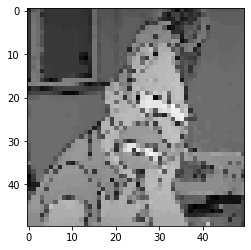

In [63]:
IMG_SIZE = 50
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

We want to create a training data set. 

In [64]:
training_data = []

def create_training_data():
    for character in characters:
        path = os.path.join(Data_directory, character)
        class_num = characters.index(character)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) 
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
            
            
create_training_data()

In [65]:
print(len(training_data))

18992


We want to randomize the number things because we dont want our machine to learn first character and guess WLOG 'lisa simpson' 100% and then move to second character and think that its 100% wrong

In [66]:
import random

random.shuffle(training_data)

In [75]:
X = []
y = []

In [76]:
for features, label in training_data:
    X.append(features)
    y.append(label)

In [77]:
X= np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #last grayscale, for rgb it would be 3

In [80]:
y = np.array(y)

Since we will be tweaking our model we don't want to have to make our dataset each time, so we will be saving our dataset. 

In [82]:
import pickle 

pickle_out = open('X.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()

In [86]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time

In [85]:
Name = 'Simpsons64x2-{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(Name))

X = pickle.load(open("X.pickle", 'rb'))
y = pickle.load(open("y.pickle", 'rb'))

X = X/255.0

model = Sequential()
model.add(Conv2D(64,(3,3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss = 'categorical_crossentropy', 
              optimizer = "adam", 
              metrics = 'mean_squared_error')

model.fit(X,y, batch_size=32, epochs =3, validation_split=0.1, callbacks=[tensorboard])


Epoch 1/3
535/535 [==============================] - 58s 109ms/step - loss: 1.0398e-06 - mean_squared_error: 92.4668 - val_loss: 1.0473e-06 - val_mean_squared_error: 93.4204
Epoch 2/3
535/535 [==============================] - 57s 106ms/step - loss: 1.0398e-06 - mean_squared_error: 92.4668 - val_loss: 1.0473e-06 - val_mean_squared_error: 93.4204
Epoch 3/3
535/535 [==============================] - 62s 116ms/step - loss: 1.0398e-06 - mean_squared_error: 92.4666 - val_loss: 1.0473e-06 - val_mean_squared_error: 93.4204


The test model above is clearly not performing well so we will try to optimize our model. 

In [87]:
dense_layers = [0, 1, 2]
layer_sizes = [64, 128, 256]
conv_layers = [2, 3, 4]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            Name = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer,layer_size,dense_layer,int(time.time()))
            tensorboard = TensorBoard(log_dir='logs/{}'.format(Name))
            print(Name)
            model = Sequential()
            model.add(Conv2D(layer_size,(3,3), input_shape = X.shape[1:]))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2)))
            
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size,(3,3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2)))
            
            model.add(Flatten())
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            model.compile(loss = 'categorical_crossentropy', 
                          optimizer = "adam", 
                          metrics='mean_squared_error')

            model.fit(X,y, batch_size=32,  validation_split=0.1, callbacks=[tensorboard])



2-conv-64-nodes-0-dense-1608628229
535/535 [==============================] - 50s 94ms/step - loss: 1.0398e-06 - mean_squared_error: 92.5706 - val_loss: 1.0473e-06 - val_mean_squared_error: 93.5272
3-conv-64-nodes-0-dense-1608628283
535/535 [==============================] - 62s 117ms/step - loss: 1.0398e-06 - mean_squared_error: 92.4046 - val_loss: 1.0473e-06 - val_mean_squared_error: 93.3620
4-conv-64-nodes-0-dense-1608628347
535/535 [==============================] - 85s 159ms/step - loss: 1.0398e-06 - mean_squared_error: 92.6902 - val_loss: 1.0473e-06 - val_mean_squared_error: 93.6497
2-conv-128-nodes-0-dense-1608628435
535/535 [==============================] - 137s 257ms/step - loss: 1.0398e-06 - mean_squared_error: 92.2766 - val_loss: 1.0473e-06 - val_mean_squared_error: 93.2349
3-conv-128-nodes-0-dense-1608628575
535/535 [==============================] - 150s 281ms/step - loss: 1.0398e-06 - mean_squared_error: 92.4675 - val_loss: 1.0473e-06 - val_mean_squared_error: 93.4268
4-

## Conclusion

Kaggle data provider has given us hdf5 format so we used that for our final model. 
The final model includes color. We have a decent model with 6 convolution layers. We also see that the standard threshold of 0.5 works very well but the 0.6 works better for some characters. 

We would conclude that our model has successfully classified the characters in Simpsons. 